In [22]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing 

df = pd.read_parquet('data/df_groupby_ip.parquet.gzip')
df.head(5)

,ip,count,size,is_bot
0,1.14.96.114,21,184774,1
1,1.145.209.230,1,8786,0
2,1.192.0.148,1,1579532,0
3,1.192.1.4,1,461240,0
4,1.231.29.243,7,70907,0


Escalo datos

In [23]:
df_robust_scaler = preprocessing.RobustScaler().fit_transform(df[["count", "size", "is_bot"]])
df_robust_scaler = pd.DataFrame(df_robust_scaler, columns=["count", "size", "is_bot"])

### KMedias

2 0.28077288898071256
3 0.2766781079465523
4 0.35712197504015497
5 0.3938532690854142
6 0.4998190881369937
7 0.5047907030114188
8 0.5072699144822048
9 0.49293161883125375


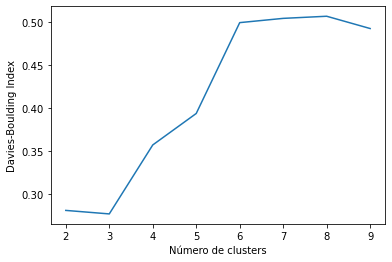

In [24]:
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans

# Creo un diccionario con el indice de David Bouldin 
db_indexes = {}
for n in range(2,10):
    kmeans = KMeans(n).fit(df_robust_scaler.values)
    db_index = davies_bouldin_score(df_robust_scaler.values, kmeans.labels_)
    print(n, db_index)
    db_indexes.update({n: db_index})

# Grafico
plt.plot(list(db_indexes.keys()), list(db_indexes.values()))
plt.xlabel("Número de clusters")
plt.ylabel("Davies-Boulding Index")
plt.show()

Probamos con un N = 3 para KMeans y asigno clusters a dataframe original y al dataframe escalado

In [25]:
n_clusters = 3
kmeans = KMeans(n_clusters).fit(df_robust_scaler.values)
df["cluster"] = kmeans.labels_
df_robust_scaler["cluster"] = kmeans.labels_

### Grafico 

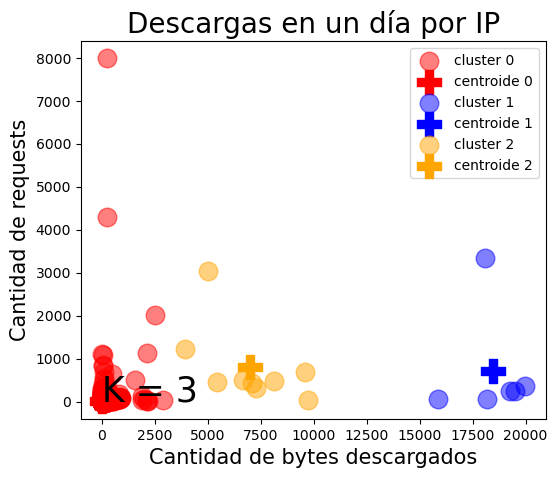

In [26]:
plt.figure(figsize=(6, 5), dpi=100)

colores = ["red", "blue", "orange", "black", "purple", "pink", "brown"]
for cluster in range(kmeans.n_clusters):
    plt.scatter(df_robust_scaler[df_robust_scaler["cluster"] == cluster]["count"],
                df_robust_scaler[df_robust_scaler["cluster"] == cluster]["size"],
                marker="o", s=180, color=colores[cluster], alpha=0.5, label='cluster ' + str(cluster))
    
    plt.scatter(kmeans.cluster_centers_[cluster][0], 
                kmeans.cluster_centers_[cluster][1], 
                marker="P", s=280, color=colores[cluster], label='centroide ' + str(cluster) )

plt.legend()

plt.title("Descargas en un día por IP", fontsize=20)
plt.xlabel("Cantidad de bytes descargados", fontsize=15)
plt.ylabel("Cantidad de requests", fontsize=15)
plt.text(1.15, 0.2, "K = %i" % kmeans.n_clusters, fontsize=25)
plt.show()

A continuación se utilizará la técnica de [Arbol de clasificación](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) para explicar que criterios se usaron para el clustering

|--- accesos <= 3413.00
|   |--- class: 0
|--- accesos >  3413.00
|   |--- accesos <= 12800.00
|   |   |--- class: 2
|   |--- accesos >  12800.00
|   |   |--- class: 1



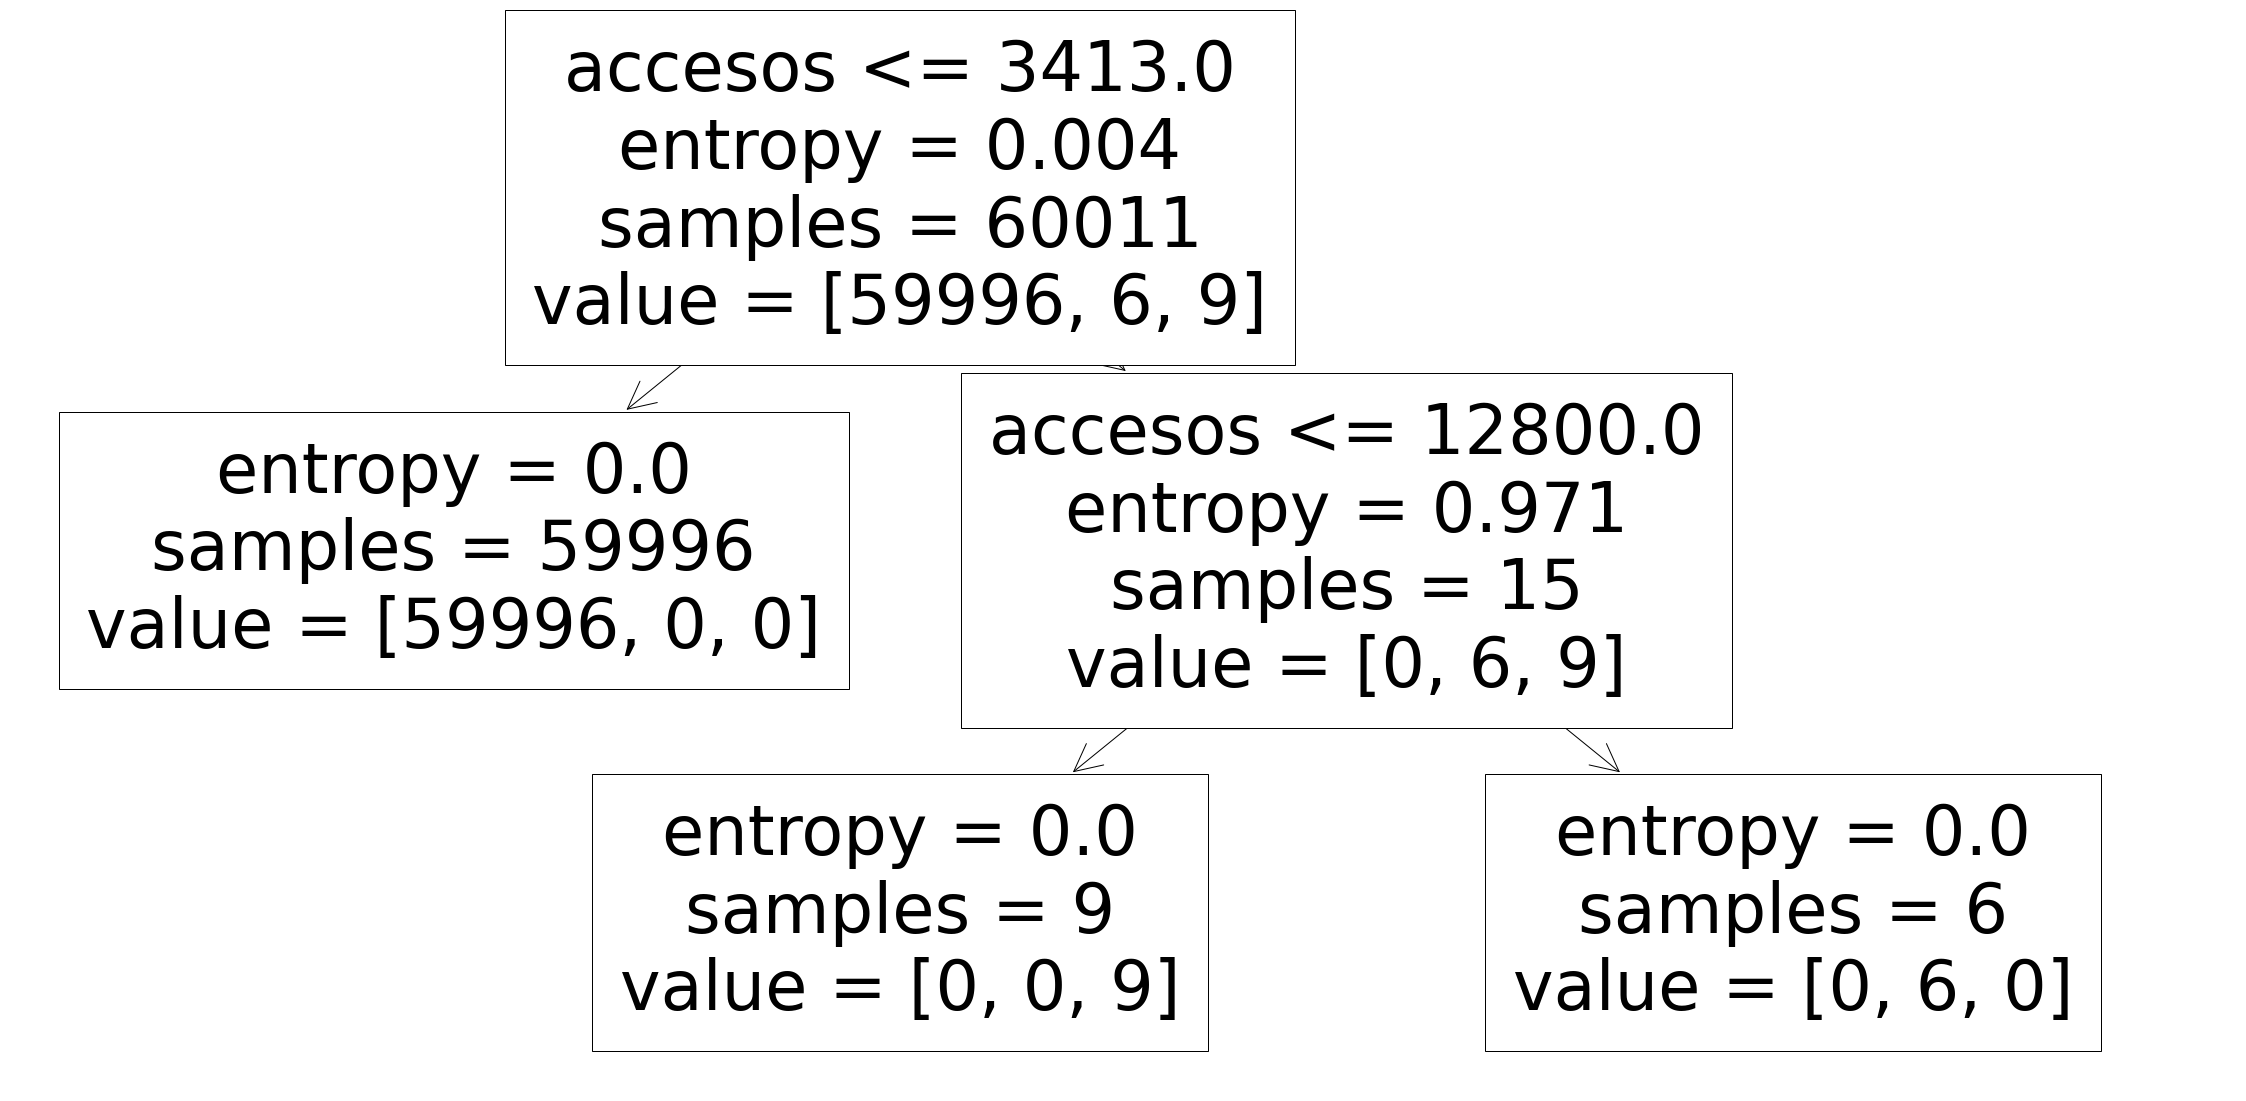

In [28]:
from sklearn import tree

arbol_decision = tree.DecisionTreeClassifier(criterion="entropy")

arbol = arbol_decision.fit(df[["count", "size", "is_bot"]], df["cluster"])

print(tree.export_text(arbol, feature_names=["accesos", "bytes", "bot"]))
plt.figure(figsize=(40, 20))
tree.plot_tree(arbol, feature_names=["accesos", "bytes", "bot"])
plt.show()



In [29]:
for i in range(kmeans.n_clusters):
    print('Accesos en cluster {}: '.format(i) + str(len(df[df['cluster'] == i])))
    print('Bots declarados en cluster {}: '.format(i) + str(len(df[(df['cluster'] == i) & (df['is_bot'] == 1)])))

Accesos en cluster 0: 59996
Bots declarados en cluster 0: 2986
Accesos en cluster 1: 6
Bots declarados en cluster 1: 5
Accesos en cluster 2: 9
Bots declarados en cluster 2: 9


In [30]:
df[df['cluster'] != 0]

,ip,count,size,is_bot,cluster
1272,136.243.187.156,9735,83041853,1,2
4118,157.55.39.163,9565,1439272513,1,2
45562,193.235.141.134,15865,128781517,0,1
45864,199.47.82.18,5002,6335088395,1,2
52761,207.46.13.10,6678,1029070777,1,2
52762,207.46.13.214,8130,980282998,1,2
53304,23.22.35.162,19476,532490012,1,1
53493,3.224.220.101,19952,732301919,1,1
54382,40.77.167.23,7273,670634075,1,2
54383,40.77.167.46,7072,904939233,1,2


In [43]:
df_raw = pd.read_parquet('data/df_log.parquet.gzip')
df_raw = df_raw.convert_dtypes()
df_raw[df_raw['ip'] == '193.235.141.134'][['user_agent']].values

array([['Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36'],
       ['Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36'],
       ['Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36'],
       ...,
       ['Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36'],
       ['Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36'],
       ['Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36']],
      dtype=object)